The following is a simple backtest of a betting strategy based on the Kelly criteron. I'll try to compare different fractions of the criterion and see which has the best returns.

This experiment is inspired by the following [paper](http://www.edwardothorp.com/wp-content/uploads/2016/11/KellySimulationsNew.pdf) by Edward O. Thorp et al.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats._continuous_distns import _distn_names

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [3]:
league = 'it'

In [4]:
df = pd.read_csv(f'{league}_odds_2021.csv')

The columns we need are:
- FTR - Full time result (either **H**ome or **A**way)
- AvgH - average odds for the home team to win
- AvgA - average odds for the away team to win
- AvgD - average odds for a draw

In [5]:
o_cols = ['FTR', 'AvgH', 'AvgA', 'AvgD']
df = df.filter(o_cols)

To better understand the data, and to possibly find a method of picking the winning team. We can plot a histogram of the odds of the winning teams of the past two seasons.

In [6]:
df_train = pd.concat(map(pd.read_csv, [f'{league}_odds_2019.csv', f'{league}_odds_2020.csv']), ignore_index=True)
df_train = df_train.filter(o_cols)

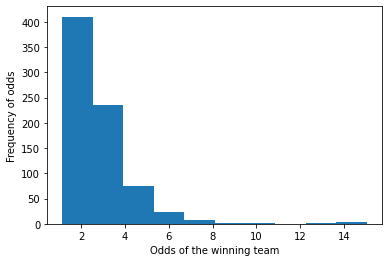

DescribeResult(nobs=760, minmax=(1.14, 15.04), mean=2.780171052631579, variance=2.594157941716941, skewness=2.8962274667606267, kurtosis=15.008331328036238)

In [7]:
ideal_odds = np.zeros(len(df_train))
for i, row in df_train.iterrows():
    ideal_odds[i] = row['Avg'+row['FTR']]

plt.hist(ideal_odds)
plt.xlabel("Odds of the winning team")
plt.ylabel("Frequency of odds")
plt.show()

scipy.stats.describe(ideal_odds)

In [8]:
def approximate_distribution(data, bins=300):
    
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    res = []
    
    dist_names = [d for d in _distn_names if not d in ['levy_stable', 'studentized_range', 'erlang']]
    for i in dist_names:
        dist = getattr(scipy.stats, i)
        
        try:
            params = dist.fit(data)

            arg = params[:-2]
            loc = params[-2]
            scale = params[-1]

            pdf = dist.pdf(x, loc=loc, scale=scale, *arg)
            sse = np.sum(np.power(y-pdf, 2))

            res.append((dist, params, sse))
        except:
            pass
        
    return sorted(res, key=lambda x:x[2])

In [9]:
res = approximate_distribution(ideal_odds)

(<scipy.stats._continuous_distns.exponnorm_gen object at 0x7fbd848f6700>, (40.33911747430781, 1.1880325678457941, 0.03946885517594641), 0.8409808032148268)


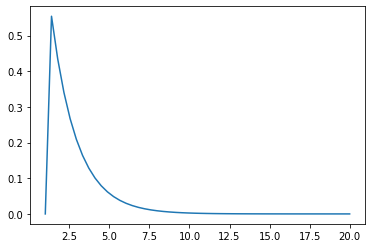

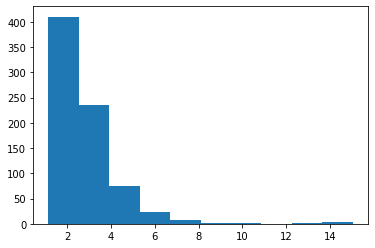

0.008007612401902627
0.0


In [10]:
r = res[0]
print(r)
dist = r[0](*r[1])

x = np.linspace(1, 20)

plt.plot(x, dist.pdf(x))
plt.show()

plt.hist(ideal_odds)
plt.show()

test_odd = 1.1
print(dist.pdf(test_odd))
print(scipy.stats.percentileofscore(ideal_odds, test_odd)/100)

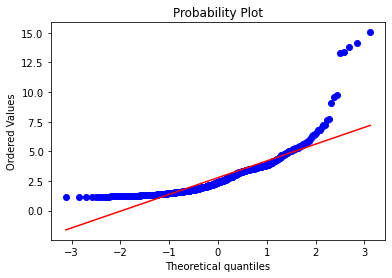

In [11]:
_ = scipy.stats.probplot(ideal_odds, plot=plt)

Assume we start with a balance of $100.

The strategy is to pick the outcome with the highest probability (and therefore lowest odds) and place Kelly bets on the outcome.

The formula for placing Kelly bets is,
$$f = p + \frac{p-1}{b}$$

where:
- $f$ is the fraction of our capital we bet
- $p$ is the probability of winning
- $b$ is the ratio of return (i.e 2-to-1 = 2.0)

Here, $b$ is the odds which the bookmaker provides, though $p$ needs to be more carefully thought out.

In previous iterations of this strategy, I chose to trust the bookmaker and set $p = \frac{1}{b}$ as the probability of the side chosen winning. However, this almost always led to negative returns as we are always betting

$$f = \frac{1}{b^2}$$

which leads to substantial ruin when the unlikely occurs, even with fractional Kelly bets.

Instead, I opted to estimate $p$ by using the winning odds in previous years, as seen in the data above (`ideal_odds`). Here, I essentially try to estimate the probability that the odd I have selected is the one of the winning team. I do this by using the percentile of the selected odd as $p$.

Also, if an odd is greater than the value of the first quartile of the winning odds, we choose not to take this bet as we deem it carries too much risk.

In [12]:
def run_kelly(X, k_factor, can_plot, metric=None):
    starting_bal = 1000
    bal = starting_bal
    bet = 0
    
    bal_history = np.zeros(len(X))
    result_history = ['w']*len(X)
    
    outcomes = ['H', 'A', 'D']
    
    dist_exp = dist.expect()
    for i, row in X.iterrows():
        all_odds = row.drop('FTR')
        
        bal_history[i] = bal
        
        idx = np.argmin(all_odds) + 1
        odds = row[idx]
        
        if metric is None:
            moment = scipy.stats.moment(ideal_odds, moment=4)
            metric = np.quantile(ideal_odds, moment*np.min(ideal_odds)/np.sum(ideal_odds))
        
        #if odds > np.quantile(ideal_odds, 0.15):
        if odds > metric:
            continue

        p = dist.pdf(odds)
        
        if pd.isna(p):
            continue
            
        bet = (p + (p-1)/odds)*k_factor
        
        if bet < 0:
            continue
        
        bet_amt = bet*bal
        bal -= bet_amt
        
        if row['FTR'] == outcomes[idx-1]:
            bal += bet_amt*odds
            result_history[i] = 'g'
        else:
            result_history[i] = 'r'

        if bal <= 0:
            break
            
    def generate_plots():
        fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [10, 1], 'hspace': 0})

        axs[0].plot(np.log(bal_history))

        for i, col in enumerate(result_history):
            axs[1].scatter(i, 0, c=col, marker='|', linewidths=[0.8])

        axs[1].axes.get_yaxis().set_visible(False)
        axs[1].axes.get_xaxis().set_visible(False)
        plt.show()

        bet_acc = result_history.count('g')/(result_history.count('g') + result_history.count('r'))*100
        print(f"Final balance of ${bal:.2f} with a maximum of ${max(bal_history):.2f}, returns of {((bal - starting_bal)/starting_bal)*100:.2f}%")
        print(f"This strategy had a winning rate of {bet_acc:.2f}%")

    if can_plot:
        generate_plots()
    
    return bal

As we've opted to use fractional Kelly bets where we bet ($\alpha \cdot f \cdot s$) (where $\alpha \in \mathbb{R}$, $\alpha \leq 1$) of our capital $s$. Now, we need to find the best $\alpha$.

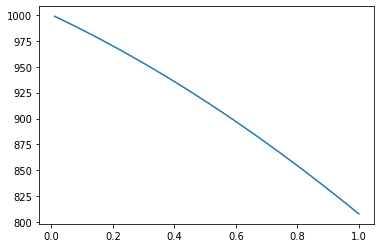

In [13]:
factors = np.linspace(0.01, 1, 25)
bals = np.empty(len(factors))

for i in range(len(factors)):
    bals[i] = run_kelly(df, factors[i], False)
    
plt.plot(factors, bals)

A rough estimate of the maximal $\alpha$ is $1$ and we arrive at our final strategy. This current strategy will theoretically benefit from leverage, however leverage in betting is typically not feasible.

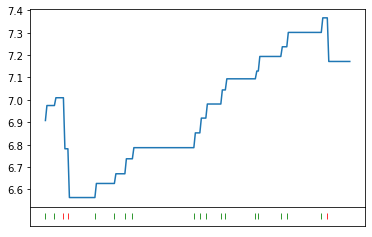

Final balance of $1301.66 with a maximum of $1581.56, returns of 30.17%
This strategy had a winning rate of 84.21%


1301.6572488216073

In [18]:
run_kelly(df, 0.8, True, metric=np.quantile(ideal_odds, 0.1))

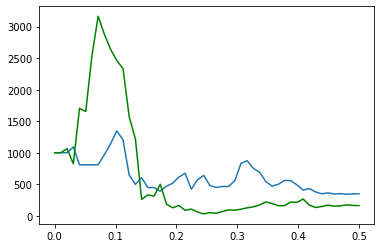

Optimal test metric of 0.1020408163265306
Optimal train metric of 0.07142857142857142


In [15]:
def find_metric():
    metrics = np.linspace(0, 0.5, 50)
    bals = np.empty(len(metrics))

    for i in range(len(metrics)):
        bals[i] = run_kelly(df, 1, False, metric=np.quantile(ideal_odds, metrics[i]))

    plt.plot(metrics, bals)

    train_bals = np.empty(len(metrics))
    for i in range(len(metrics)):
        train_bals[i] = run_kelly(df_train, 1, False, metric=np.quantile(ideal_odds, metrics[i]))

    plt.plot(metrics, train_bals, c='g')
    plt.show()
    print(f"Optimal test metric of {metrics[np.argmax(bals)]}")
    print(f"Optimal train metric of {metrics[np.argmax(train_bals)]}")